In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, roc_auc_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV
from sklearn.model_selection import TimeSeriesSplit

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
import warnings
import json

## Main Model: Voting Classifier

In [2]:
aapl_with_features = pd.read_csv('../data/all_data/all_AAPL_data.csv')
googl_with_features = pd.read_csv('../data/all_data/all_GOOGL_data.csv')
msft_with_features = pd.read_csv('../data/all_data/all_MSFT_data.csv')

In [3]:
tickers = ['AAPL', 'GOOGL', 'MSFT']
data_dict = {
    'AAPL': aapl_with_features,
    'GOOGL': googl_with_features,
    'MSFT': msft_with_features
}
color_dict = {
     'AAPL': 'grey',
    'GOOGL': 'yellow',
    'MSFT': 'green'
}

statistics = ['accuracy', 'precision', 'recall', 'roc_auc']

In [4]:
def get_target(input_df, ticker):
    df = input_df.copy()
    df['Target'] = (df[f'Close_{ticker}'].shift(-1) > df[f'Close_{ticker}']).astype(int)
    df.dropna(inplace=True)
    return df

### SEARCHING FOR BEST FEATURES BY USING RFECV

In [5]:
warnings.filterwarnings('ignore')

feature_dict = {}

for i, share in enumerate(tickers):
    feature_dict[share] = {}
    df = get_target(data_dict[share], share)
    features = [col for col in df.columns if col not in ['Target', 'index', 'DATE']]
    X = df[features]
    y = df['Target']

    
    for stat in statistics: 
        cv_split = TimeSeriesSplit(n_splits=5)
        model_judge = RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42, n_jobs=-1)
        
        #Second model to check
        ''' model_judge = XGBClassifier(
        n_estimators=50, 
        max_depth=3, 
        learning_rate=0.1, 
        n_jobs=-1, 
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    ) ''' 
        
        min_feats = 10 if share=='AAPL' else 7
        rfecv = RFECV(
        estimator=model_judge,
        min_features_to_select=min_feats,
        step=1,
        cv=cv_split,
        scoring= stat,
        n_jobs=-1)
    
        rfecv.fit(X, y)    
        print(f"Optimal features numer: {rfecv.n_features_}")
        selected_features = [f for f, s in zip(features, rfecv.support_) if s]
        print(f"Winner features for {stat} ({len(selected_features)}):")
        print(selected_features)
        feature_dict[share][stat] = selected_features

with open("../models_results/feature_dict.json", "w") as f:
    json.dump(feature_dict, f, indent=4)
    
print(feature_dict)
    


Optimal features numer: 11
Winner features for accuracy (11):
['RSI_14', 'BBM_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'Close_VIX', 'VIX_percent', 'Volume_GOOGL', 'log_return', 'cusum', 'cusum_pos', 'cusum_neg']
Optimal features numer: 17
Winner features for precision (17):
['High_AAPL', 'RSI_14', 'MACD_12_26_9', 'MACDh_12_26_9', 'ATRr_14', 'BBM_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'DGS10', 'USEPUINDXD', 'Close_VIX', 'VIX_percent', 'Volume_GOOGL', 'log_return', 'cusum', 'cusum_pos', 'cusum_neg']
Optimal features numer: 11
Winner features for recall (11):
['RSI_14', 'BBM_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'Close_VIX', 'VIX_percent', 'Volume_GOOGL', 'log_return', 'cusum', 'cusum_pos', 'cusum_neg']
Optimal features numer: 12
Winner features for roc_auc (12):
['RSI_14', 'MACDh_12_26_9', 'BBM_20_2.0_2.0', 'BBB_20_2.0_2.0', 'BBP_20_2.0_2.0', 'Close_VIX', 'VIX_percent', 'Volume_GOOGL', 'log_return', 'cusum', 'cusum_pos', 'cusum_neg']
Optimal features numer: 9

In [6]:
result_dict = {}
for i, share in enumerate(tickers):
    df = get_target(data_dict[share], share)
    features = [col for col in df.columns if col not in ['Target', 'index', 'DATE']]

    X = df[features]
    y = df['Target']
    result_dict[share] = {}

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    
    for stat in statistics:
        selected_cols = feature_dict[share][stat]
    
        rf_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('rf', RandomForestClassifier(n_estimators=100, max_depth=4, min_samples_leaf=10, random_state=42, n_jobs=-1))
        ])
        
        svm_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('svc', SVC(kernel='rbf', C=1.0, gamma='scale', probability=True, random_state=42)),
        ])
        
        xgb_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('xgb', XGBClassifier(n_estimators=50, max_depth=3,learning_rate=0.1,eval_metric='logloss', random_state=42, n_jobs=-1)),
        ])
    
        main_model = VotingClassifier(estimators=[('xgb', xgb_pipeline),('svc', svm_pipeline),('rf', rf_pipeline),],
                                      voting='soft')
        
        main_model.fit(X_train[selected_cols], y_train)
    
        y_pred = main_model.predict(X_test[selected_cols])
        acc = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_pred)
        print('*' * 40)
        print(f"Results for {share} for best stat: {stat}:")
        print("Accuracy:", acc)
        print("Precision:", precision)
        print("Recall:", recall)
        print("ROC AUC score:", roc_auc)
        result_dict[share][stat] = [acc, precision, recall, roc_auc]
    
    
    

****************************************
Results for AAPL for best stat: accuracy:
Accuracy: 0.5273088381330685
Precision: 0.5291576673866091
Recall: 0.9245283018867925
ROC AUC score: 0.5052410901467506
****************************************
Results for AAPL for best stat: precision:
Accuracy: 0.5233366434955313
Precision: 0.5314861460957179
Recall: 0.7962264150943397
ROC AUC score: 0.5081761006289308
****************************************
Results for AAPL for best stat: recall:
Accuracy: 0.5273088381330685
Precision: 0.5291576673866091
Recall: 0.9245283018867925
ROC AUC score: 0.5052410901467506
****************************************
Results for AAPL for best stat: roc_auc:
Accuracy: 0.522343594836147
Precision: 0.5263724434876211
Recall: 0.9226415094339623
ROC AUC score: 0.500104821802935
****************************************
Results for GOOGL for best stat: accuracy:
Accuracy: 0.5273088381330685
Precision: 0.5307377049180327
Recall: 0.9664179104477612
ROC AUC score: 0.49700

In [190]:
result_by_stats = {}
for stat in statistics:
    result_by_stats[stat] = {}
    for share in tickers:
        result_by_stats[stat][share] = result_dict[share][stat]
    df_to_save = pd.DataFrame.from_dict(
        result_by_stats[stat], 
        orient='index',
        columns=['accuracy', 'precision', 'recall', 'roc_auc'])
    print('*'*10, f'Results for {stat}', '*'*10)
    print(df_to_save)
    df_to_save.to_csv(f'../models_results/main_model_results_by_{stat}.csv')

********** Results for accuracy **********
       accuracy  precision    recall   roc_auc
AAPL   0.522344   0.526372  0.922642  0.500105
GOOGL  0.536246   0.535751  0.964552  0.506692
MSFT   0.526316   0.526953  0.910646  0.508338
********** Results for precision **********
       accuracy  precision    recall   roc_auc
AAPL   0.518371   0.529880  0.752830  0.505346
GOOGL  0.546177   0.541535  0.960821  0.517565
MSFT   0.517378   0.520534  0.963878  0.496492
********** Results for recall **********
       accuracy  precision    recall   roc_auc
AAPL   0.518371   0.526377  0.847170  0.500105
GOOGL  0.527309   0.530738  0.966418  0.497009
MSFT   0.526316   0.525871  0.946768  0.506648
********** Results for roc_auc **********
       accuracy  precision    recall   roc_auc
AAPL   0.517378   0.525404  0.858491  0.498428
GOOGL  0.509434   0.527132  0.761194  0.492062
MSFT   0.522344   0.523030  0.971483  0.501334


********** accuracy **********
   Ticker  accuracy  precision    recall   roc_auc                Model
0    AAPL  0.532274   0.572728  0.507338  0.507338        Random Forest
1    AAPL  0.531281   0.530021  0.966038  0.507128                  SVM
2    AAPL  0.528302   0.534913  0.807910  0.506390  Logistic Regression
3    AAPL  0.527110   0.527110  1.000000  0.500000          Always rise
4    AAPL  0.522927   0.541005  0.630763  0.516648         Based on SMA
5    AAPL  0.522344   0.526372  0.922642  0.500105      Ensemble (Main)
6    AAPL  0.499404   0.525245  0.525245  0.497917   Based on yesterday
7    AAPL  0.486594   0.494415  0.494969  0.494969              XGBoost
8   GOOGL  0.536246   0.535751  0.964552  0.506692      Ensemble (Main)
9   GOOGL  0.523337   0.523337  1.000000  0.500000          Always rise
10  GOOGL  0.508441   0.522956  0.871269  0.483405                  SVM
11  GOOGL  0.501396   0.520700  0.589558  0.497120         Based on SMA
12  GOOGL  0.500795   0.522960  0

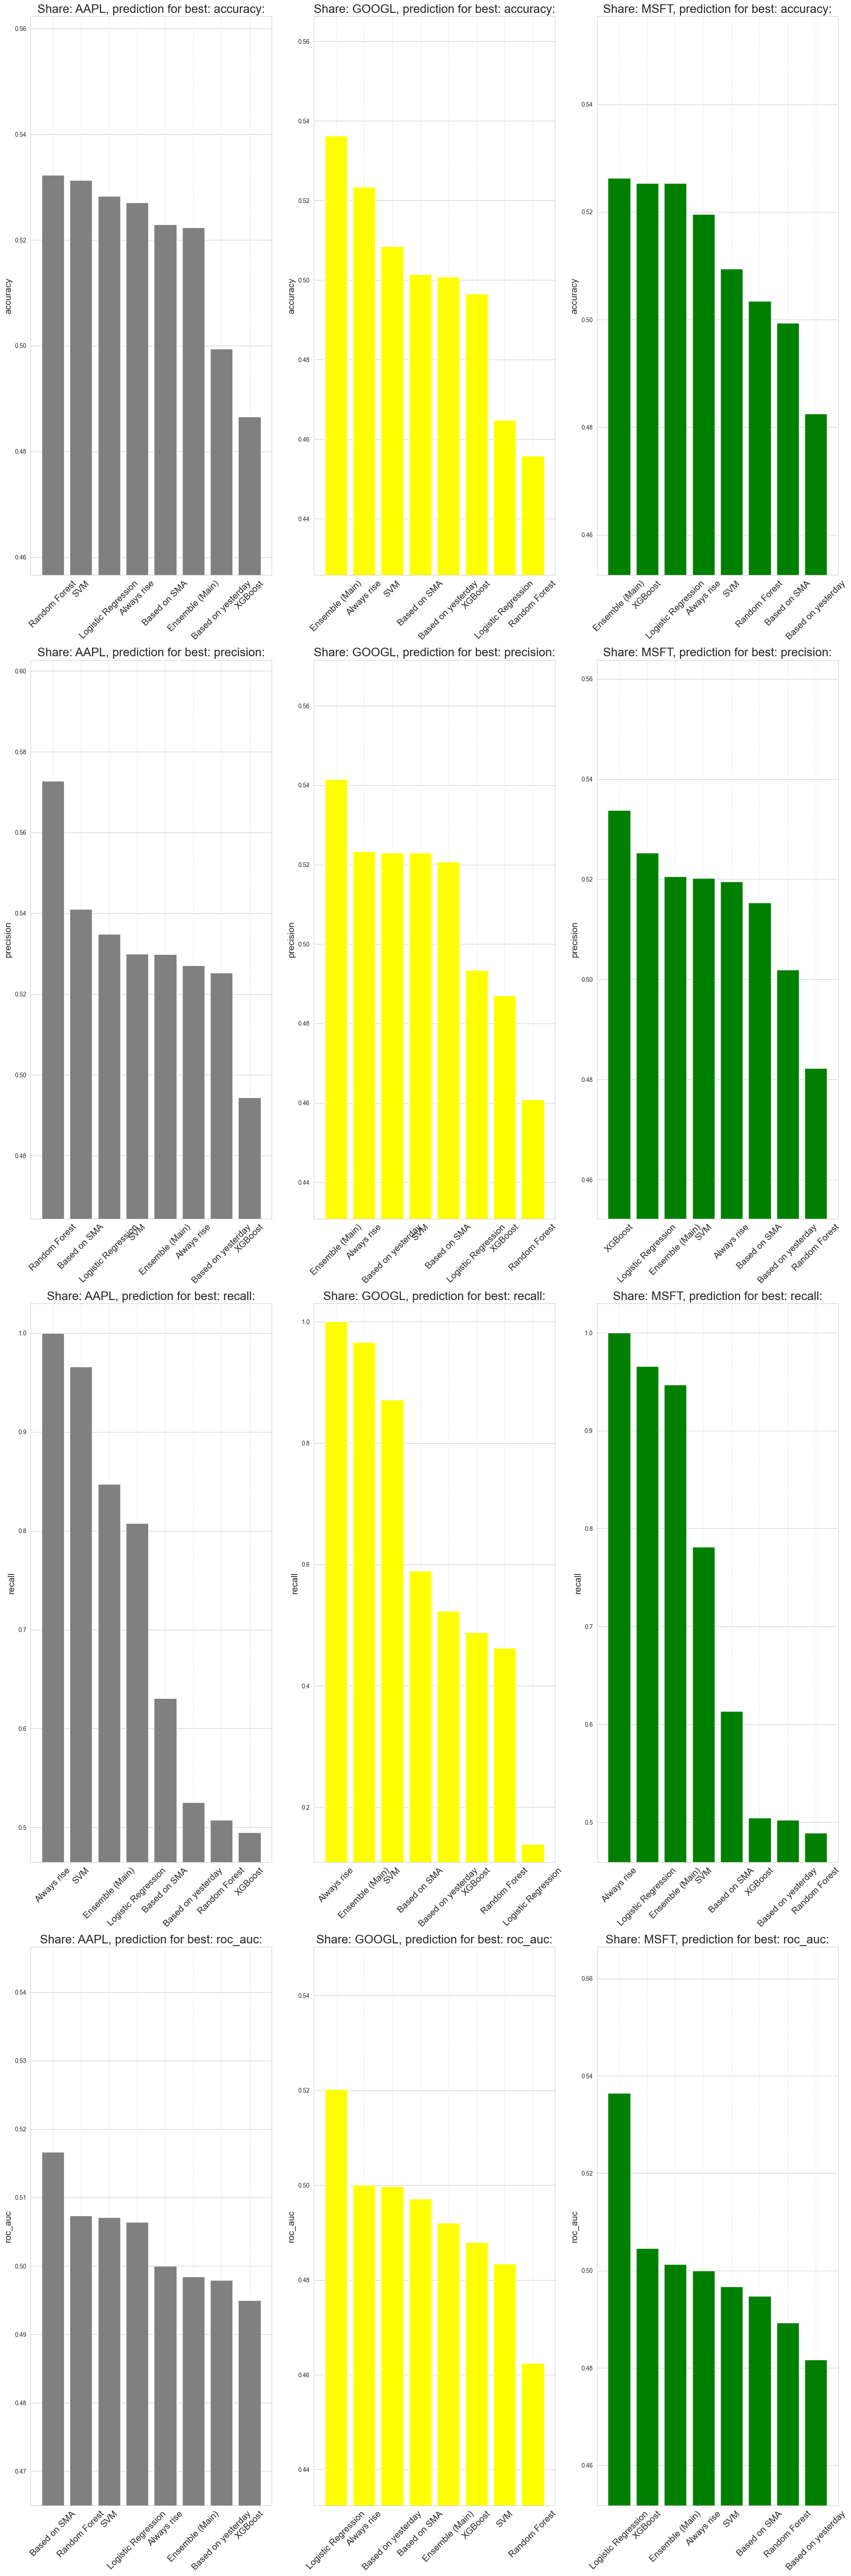

In [9]:
rf_results = pd.read_csv('../models_results/RF_results.csv')
svm_results = pd.read_csv('../models_results/SVM_results.csv')
xgb_results = pd.read_csv('../models_results/XGB_results.csv')
lr_results = pd.read_csv('../models_results/LR_results.csv')
bs1_results = pd.read_csv('../models_results/bs1_results.csv')
bs2_results = pd.read_csv('../models_results/bs2_results.csv')
bs3_results = pd.read_csv('../models_results/bs3_results.csv')
main_model_acc = pd.read_csv('../models_results/main_model_results_by_accuracy.csv')
main_model_precision = pd.read_csv('../models_results/main_model_results_by_precision.csv')
main_model_recall = pd.read_csv('../models_results/main_model_results_by_recall.csv')
main_model_roc_auc = pd.read_csv('../models_results/main_model_results_by_roc_auc.csv')

bs1_results['Model'] = 'Based on yesterday'
bs2_results['Model'] = 'Always rise'
bs3_results['Model'] = 'Based on SMA'
rf_results['Model'] = 'Random Forest'
svm_results['Model'] = 'SVM'
xgb_results['Model'] = 'XGBoost'
lr_results['Model'] = 'Logistic Regression'
main_model_acc['Model'] = 'Ensemble (Main)'
main_model_precision['Model'] = 'Ensemble (Main)'
main_model_recall['Model'] = 'Ensemble (Main)'
main_model_roc_auc['Model'] = 'Ensemble (Main)'

all_dfs_acc = [bs1_results, bs2_results, bs3_results, rf_results, svm_results, xgb_results, lr_results, main_model_acc]
all_dfs_precision = [bs1_results, bs2_results, bs3_results, rf_results, svm_results, xgb_results, lr_results, main_model_precision]
all_dfs_recall = [bs1_results, bs2_results, bs3_results, rf_results, svm_results, xgb_results, lr_results, main_model_recall]
all_dfs_roc_auc = [bs1_results, bs2_results, bs3_results, rf_results, svm_results, xgb_results, lr_results, main_model_roc_auc]

all_dfs = [all_dfs_acc, all_dfs_precision, all_dfs_recall, all_dfs_roc_auc]

fig, axes = plt.subplots(4, 3, figsize=(20, 60))

for num, stat in enumerate(statistics):

    combined_df = pd.concat(all_dfs[num])
    
    if 'Unnamed: 0' in combined_df.columns:
        combined_df = combined_df.rename(columns={'Unnamed: 0': 'Ticker'})
    
    combined_df = combined_df.sort_values(by=['Ticker', stat], ascending=[True, False])
    
    combined_df = combined_df.reset_index(drop=True)
    
    print('*' * 10, stat, '*' * 10)
    print(combined_df)
    
    for i, t in enumerate(combined_df['Ticker'].unique()):
        subsets = combined_df[combined_df['Ticker'] == t]
        subsets = subsets.sort_values(by=stat, ascending=False)
        
        y_min = subsets[stat].min() - 0.03
        y_max = subsets[stat].max() + 0.03
        
        axes[num][i].bar(subsets['Model'], subsets[stat], color=color_dict[t])
        axes[num][i].set_title(f'Share: {t}, prediction for best: {stat}:', size=20)
        axes[num][i].set_ylim(y_min, ymax=y_max)
        axes[num][i].grid(axis='x', alpha=0.5, linestyle='--')
        axes[num][i].set_ylabel(stat, fontsize=15)
        axes[num][i].tick_params(axis='x', labelsize=15, labelrotation=45)
plt.tight_layout()
plt.show()



